# Simulations of Queue-Dispatcher Model

This code written by Ryan T. White is used in the paper:

Jewgeni H. Dshalalow and Ryan T. White. Level Crossing Analysis in a State Dependent Single Vacation Queue.

## Exponential $\delta_i$, Geometric $Y_i$, Exponential $x_i$

In this special case, assume

* $x_i$'s are *i.i.d.* with exponential($\xi$) distribution
* $\delta_i$'s are independent of $x_i$'s and are *i.i.d.* with exponential($\lambda$) distribution
* $Y_i$'s are independent of $x_i$'s and $\delta_i$'s and are *i.i.d.* with geometric($p$) distribution

We will write a function that simulates one path of the process to be re-called in Monte Carlo simulation.

* Note that the `numpy` implementation of exponential random number generator uses the inverse of the parameter we use.

The function will take inputs:
* $\xi$ - parameter of the dispatcher-estimated service times $x_i$
* $p$ - parameter of the arriving customer batch size $Y_i$
* $\lambda$ - arrival process parameter, i.e. it controls the waiting times $\delta_i$ between arrivals (it is called `lam` to avoid the Python reserved command `lambda`)
* $T$ - the vacation time if there are no arrivals

The function will return:
* $A_{\nu-1}$ - the pre-return level
* $S_\nu$ - the return level
* $t_{\nu-1}$ - the pre-return time
* $\tau_\nu$ - the return time
* $Q_\nu$ - the queue length upon return

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')

def simulatePath(lam, xi, p, T):
    # initialize outputs
    returnLevel = 0
    returnTime = 0
    returnQueue = 0
    vacationCompleted = False
    
    while returnLevel < T:
        # save t_j-1
        oldTime = returnTime
        
        # save A_j-1
        oldLevel = returnLevel
        
        # save B_j-1
        oldQueue = returnQueue
        
        # compute the waiting time before the next arrival
        waitingTime = np.random.exponential(1/lam)
        
        # if return level plus waiting time exceeds T, server returns
        if returnLevel + waitingTime > T:
            # set return level to T
            returnLevel = T
            
            # set return time to t_nu-1 + T - A_nu-1
            returnTime = oldTime + T - oldLevel
            
            # set return queue length to B_nu-1
            # (done above)
            
            # mark vacation as finished
            vacationCompleted = True
            
            # exit the loop
            break
            
        # if return time plus waiting time does not exceed T, proceed to time t_j
        else:
            # compute batch size
            batchSize = np.random.geometric(p)
            
            # compute queue length B_j
            returnQueue += batchSize
            
            # compute estimated batch service time
            estimatedServiceTime = np.sum(np.random.exponential(1/xi, batchSize))
            
            # add waiting time and estimated service time to A_j
            returnLevel += waitingTime + estimatedServiceTime
            
            # add waiting time to return time
            returnTime += waitingTime
            
    outputs = (oldLevel, returnLevel,
               oldTime, returnTime,
               returnQueue,
               vacationCompleted)
    
    return outputs

def returnQueueMean(lam, xi, p, T):
    b = lam + p * xi
    frac = lam / (p * b ** 2)
    num = lam * (1 - np.exp(-b*T)) + b * p * xi * T
    return frac * num

def returnTimeMean(lam, xi, p, T):
    b = lam + p * xi
    frac = 1 / b ** 2
    num = lam * (1 - np.exp(-b*T)) + b * p * xi * T
    return frac * num

def returnQueueVariance(lam, xi, p, T):
    derivative1 = returnQueueMean(lam, xi, p, T)
    
    b = lam + p * xi
    eplus = np.exp(b*T)
    eminus = np.exp(-b*T)
    
    multiplier = lam * eminus / (p**2 * b**4)
    
    inside = 2 * eplus * (1-p) * (p*xi)**4 * T

    inside2 = -8 + 2 * p**2 * xi * T + p * (6 - 2 * xi * T)
    inside2 += eplus*(8 + p**2 * xi * T * (xi*T - 4) + 2*p*(xi*T - 3))
    inside += lam * (p * xi)**2 * inside2
    
    inside3 = 2*(p + p**2 * xi * T - 1)
    inside3 += eplus*(2 + (p*xi*T)**2 + 2*p*(xi*T - 1))
    inside += lam**3 * inside3

    inside4 = (2*p - 1)*(2 + p*xi*T)
    inside4 += eplus*(2 + p*(xi*T - 4) + p**2 * xi * T * (xi*T - 1))
    inside += 2 * lam**2 * p * xi * inside4
    
    derivative2 = multiplier * inside
    
    variance = derivative2 + derivative1 - (derivative1) ** 2
    
    return variance
    
    #alpha = alpha0(lam, xi, p, T)
    #return alpha0pp(lam, xi, p, T) + alpha - alpha**2

def returnTimeVariance(lam, xi, p, T):
    b = lam + xi * p
    
    eminus = np.exp(-b*T)
    
    multiplier = lam / b**4
    a0 = lam - 4*p*xi + 2*p*xi*b*T
    a1 = 4*p*xi + 2*(p*xi)**2*T - 2*lam**2*T
    a2 = -lam
    inside = a0 + a1*eminus + a2*eminus**2
    
    return multiplier * inside

def vacationReturnProbability(lam, xi, p, T):
    b = lam + p * xi
    num = lam * np.exp(-b*T) + p * xi
    return num/b

def alpha0(lam, xi, p, T):
    b = lam + p*xi
    term1 = lam*xi*T / b
    term2 = (1/p) * (lam/b)**2 * (1 - np.exp(-b*T))
    return term1 + term2

def alpha0pp(lam, xi, p, T):
    b = lam + p*xi
    q = 1-p
    Lp1 = (b-lam)/(2*b**2)*T**2 + ((lam-p*xi)/b**3)*T + (lam/b**3)*T*np.exp(-b*T) + ((b-3*lam)/b**4)*(1-np.exp(-b*T))
    return (2/p)*(q*alpha0(lam, xi, p, T) + lam*Lp1)

## Testing the simulation scheme

In [2]:
xi = 5
p = 0.1
lam = 4
T = 10

results = []

print('Running simulations...\n')

for i in range(10000):
    results.append(simulatePath(lam, xi, p, T))
    if i % 1000 == 0: print('Iteration', i)
    
results = np.array(results)

print('\nComputing empirical means...\n')

means = np.mean(results[:, 3:], 0)
var = np.var(results[:, [3, 4]], 0)
empiricalResults = np.array([means[0], means[1], var[0], var[1], means[2]])

print('Computing predicted results...\n')

predictedResults = np.array([returnTimeMean(lam, xi, p, T),
                             returnQueueMean(lam, xi, p, T),
                             returnTimeVariance(lam, xi, p, T),
                             returnQueueVariance(lam, xi, p, T),
                             vacationReturnProbability(lam, xi, p, T)])

print('Empirical Results', np.round(empiricalResults, 3), '\n')
print('Predicted Results', np.round(predictedResults, 3))

Running simulations...

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000

Computing empirical means...

Computing predicted results...

Empirical Results [1.32000e+00 5.22000e+01 4.52000e-01 1.33884e+02 1.17000e-01] 

Predicted Results [1.30900e+00 5.23460e+01 4.58000e-01 1.35577e+02 1.11000e-01]


## Simulating for a Sequence of $\lambda$ and $T$ values

In [3]:
xi = 5
p = 0.5
T = 10

tList = [0.1, 0.25, 0.5, 1]

lamSpace = np.linspace(0.5, 10, 20)

empiricalCarrier = []
predictedCarrier = []

for T in tList:
    print('Vacation time T:', T)
    
    empirical = []
    predicted = []
    
    for lam in lamSpace:
        print('Waiting time parameter', lam)

        results = []

        for i in range(10000):
            results.append(simulatePath(lam, xi, p, T))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)
        
        means = np.mean(results[:, 3:], 0)
        var = np.var(results[:, [3, 4]], 0)
        empiricalResults = np.array([means[0], means[1], var[0], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([returnTimeMean(lam, xi, p, T),
                                     returnQueueMean(lam, xi, p, T),
                                     returnTimeVariance(lam, xi, p, T),
                                     returnQueueVariance(lam, xi, p, T),
                                     vacationReturnProbability(lam, xi, p, T)])

        predicted.append(predictedResults)
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Vacation time T: 0.1
Waiting time parameter 0.5
Waiting time parameter 1.0
Waiting time parameter 1.5
Waiting time parameter 2.0
Waiting time parameter 2.5
Waiting time parameter 3.0
Waiting time parameter 3.5
Waiting time parameter 4.0
Waiting time parameter 4.5
Waiting time parameter 5.0
Waiting time parameter 5.5
Waiting time parameter 6.0
Waiting time parameter 6.5
Waiting time parameter 7.0
Waiting time parameter 7.5
Waiting time parameter 8.0
Waiting time parameter 8.5
Waiting time parameter 9.0
Waiting time parameter 9.5
Waiting time parameter 10.0
Vacation time T: 0.25
Waiting time parameter 0.5
Waiting time parameter 1.0
Waiting time parameter 1.5
Waiting time parameter 2.0
Waiting time parameter 2.5
Waiting time parameter 3.0
Waiting time parameter 3.5
Waiting time parameter 4.0
Waiting time parameter 4.5
Waiting time parameter 5.0
Waiting time parameter 5.5
Waiting time parameter 6.0
Waiting time parameter 6.5
Waiting time parameter 7.0
Waiting time parameter 7.5
Waiting tim

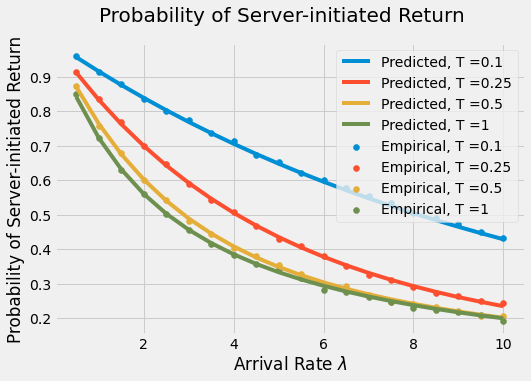

In [4]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # probability of decay crossing
    ax1.scatter(lamSpace, empiricalArray[:,-1], label = sLabel)    
    ax1.plot(lamSpace, predictedArray[:,-1], label = pLabel)

ax1.legend()
ax1.set_xlabel('Arrival Rate $\lambda$')
ax1.set_ylabel('Probability of Server-initiated Return')

fig.suptitle(r'Probability of Server-initiated Return', fontsize = 20)

plt.savefig('lambda_vs_probability.png', bbox_inches = 'tight')

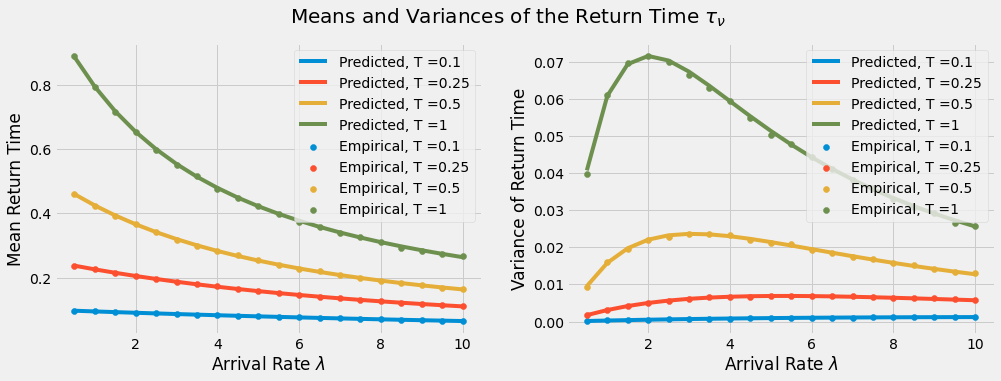

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # mean crossing time
    ax1.scatter(lamSpace, empiricalArray[:,0], label = sLabel)    
    ax1.plot(lamSpace, predictedArray[:,0], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(lamSpace, empiricalArray[:,2], label = sLabel)
    ax2.plot(lamSpace, predictedArray[:,2], label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Arrival Rate $\lambda$')
ax1.set_ylabel('Mean Return Time')

ax2.legend()
ax2.set_xlabel('Arrival Rate $\lambda$')
ax2.set_ylabel('Variance of Return Time')

fig.suptitle(r'Means and Variances of the Return Time $\tau_\nu$', fontsize = 20)

plt.savefig('lambda_vs_means_vars_return_time.png', bbox_inches = 'tight')

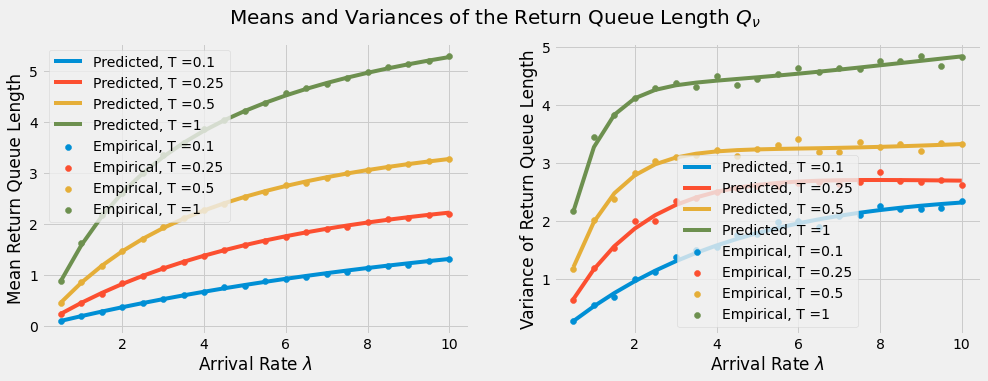

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # mean crossing time
    ax1.scatter(lamSpace, empiricalArray[:,1], label = sLabel)    
    ax1.plot(lamSpace, predictedArray[:,1], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(lamSpace, empiricalArray[:,3], label = sLabel)
    ax2.plot(lamSpace, predictedArray[:,3], label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Arrival Rate $\lambda$')
ax1.set_ylabel('Mean Return Queue Length')

ax2.legend()
ax2.set_xlabel('Arrival Rate $\lambda$')
ax2.set_ylabel('Variance of Return Queue Length')

fig.suptitle(r'Means and Variances of the Return Queue Length $Q_\nu$', fontsize = 20)

plt.savefig('lambda_vs_means_vars_return_queue.png', bbox_inches = 'tight')

## Simulating for a Sequence of $p$ and $T$ values

In [7]:
xi = 5
lam = 1

tList = [0.1, 0.5, 1, 2]

pSpace = np.linspace(0.05, 1, 20)

empiricalCarrier = []
predictedCarrier = []

for T in tList:
    print('Vacation time T:', T)
    
    empirical = []
    predicted = []
    
    for p in pSpace:
        print('Batch size parameter', p)

        results = []

        for i in range(100000):
            results.append(simulatePath(lam, xi, p, T))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)
        
        means = np.mean(results[:, 3:], 0)
        var = np.var(results[:, [3, 4]], 0)
        empiricalResults = np.array([means[0], means[1], var[0], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([returnTimeMean(lam, xi, p, T),
                                     returnQueueMean(lam, xi, p, T),
                                     returnTimeVariance(lam, xi, p, T),
                                     returnQueueVariance(lam, xi, p, T),
                                     vacationReturnProbability(lam, xi, p, T)])

        predicted.append(predictedResults)
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Vacation time T: 0.1
Batch size parameter 0.05
Batch size parameter 0.1
Batch size parameter 0.15
Batch size parameter 0.2
Batch size parameter 0.25
Batch size parameter 0.3
Batch size parameter 0.35
Batch size parameter 0.39999999999999997
Batch size parameter 0.44999999999999996
Batch size parameter 0.49999999999999994
Batch size parameter 0.5499999999999999
Batch size parameter 0.6
Batch size parameter 0.65
Batch size parameter 0.7
Batch size parameter 0.75
Batch size parameter 0.7999999999999999
Batch size parameter 0.85
Batch size parameter 0.9
Batch size parameter 0.95
Batch size parameter 1.0
Vacation time T: 0.5
Batch size parameter 0.05
Batch size parameter 0.1
Batch size parameter 0.15
Batch size parameter 0.2
Batch size parameter 0.25
Batch size parameter 0.3
Batch size parameter 0.35
Batch size parameter 0.39999999999999997
Batch size parameter 0.44999999999999996
Batch size parameter 0.49999999999999994
Batch size parameter 0.5499999999999999
Batch size parameter 0.6
Batch

Text(0.5, 0.98, 'Probability of Server-initiated Return')

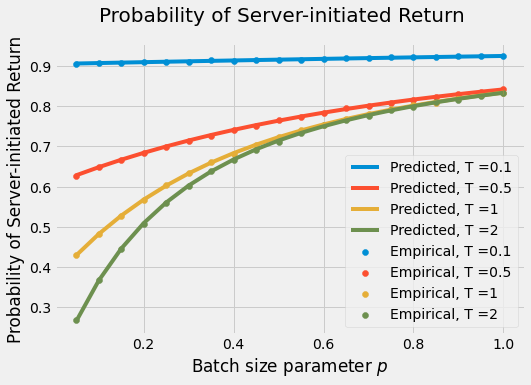

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # probability of decay crossing
    ax1.scatter(pSpace, empiricalArray[:,-1], label = sLabel)    
    ax1.plot(pSpace, predictedArray[:,-1], label = pLabel)

ax1.legend()
ax1.set_xlabel('Batch size parameter $p$')
ax1.set_ylabel('Probability of Server-initiated Return')

fig.suptitle(r'Probability of Server-initiated Return', fontsize = 20)

Text(0.5, 0.98, 'Means and Variances of the Return Time $\\tau_\\nu$')

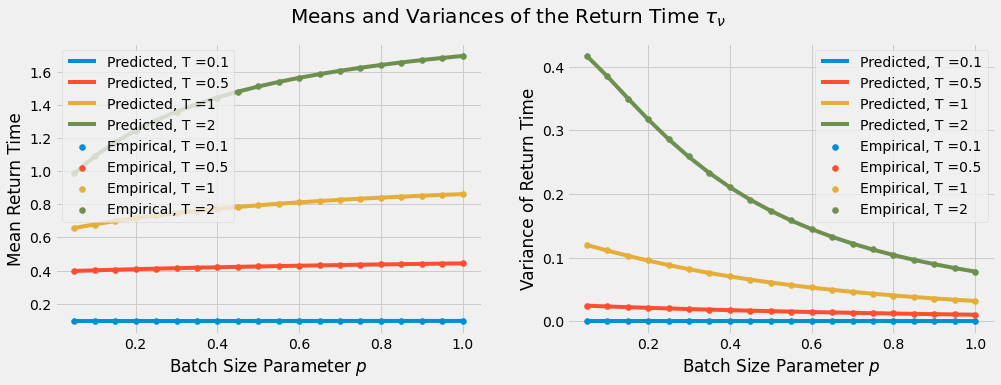

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # mean crossing time
    ax1.scatter(pSpace, empiricalArray[:,0], label = sLabel)    
    ax1.plot(pSpace, predictedArray[:,0], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(pSpace, empiricalArray[:,2], label = sLabel)
    ax2.plot(pSpace, predictedArray[:,2], label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Batch Size Parameter $p$')
ax1.set_ylabel('Mean Return Time')

ax2.legend()
ax2.set_xlabel('Batch Size Parameter $p$')
ax2.set_ylabel('Variance of Return Time')

fig.suptitle(r'Means and Variances of the Return Time $\tau_\nu$', fontsize = 20)

Text(0.5, 0.98, 'Means and Variances of the Return Queue Length $Q_\\nu$')

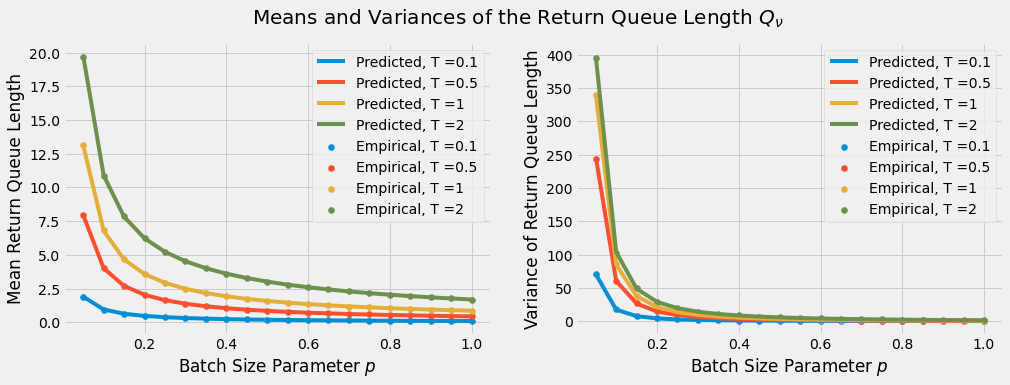

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # mean crossing time
    ax1.scatter(pSpace, empiricalArray[:,1], label = sLabel)    
    ax1.plot(pSpace, predictedArray[:,1], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(pSpace, empiricalArray[:,3], label = sLabel)
    ax2.plot(pSpace, predictedArray[:,3], label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Batch Size Parameter $p$')
ax1.set_ylabel('Mean Return Queue Length')

ax2.legend()
ax2.set_xlabel('Batch Size Parameter $p$')
ax2.set_ylabel('Variance of Return Queue Length')

fig.suptitle(r'Means and Variances of the Return Queue Length $Q_\nu$', fontsize = 20)

## Simulating for a Sequence of $\xi$ and $T$ values

In [11]:
p = 0.5
lam = 2

tList = [0.1, 0.5, 1, 2]

xiSpace = np.linspace(0.5, 10, 20)

empiricalCarrier = []
predictedCarrier = []

for T in tList:
    print('Vacation time T:', T)
    
    empirical = []
    predicted = []
    
    for xi in xiSpace:
        print('Estimated service time parameter', xi)

        results = []

        for i in range(100000):
            results.append(simulatePath(lam, xi, p, T))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)

        means = np.mean(results[:, 3:], 0)
        var = np.var(results[:, [3, 4]], 0)
        empiricalResults = np.array([means[0], means[1], var[0], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([returnTimeMean(lam, xi, p, T),
                                     returnQueueMean(lam, xi, p, T),
                                     returnTimeVariance(lam, xi, p, T),
                                     returnQueueVariance(lam, xi, p, T),
                                     vacationReturnProbability(lam, xi, p, T)])

        predicted.append(predictedResults)
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Vacation time T: 0.1
Estimated service time parameter 0.5
Estimated service time parameter 1.0
Estimated service time parameter 1.5
Estimated service time parameter 2.0
Estimated service time parameter 2.5
Estimated service time parameter 3.0
Estimated service time parameter 3.5
Estimated service time parameter 4.0
Estimated service time parameter 4.5
Estimated service time parameter 5.0
Estimated service time parameter 5.5
Estimated service time parameter 6.0
Estimated service time parameter 6.5
Estimated service time parameter 7.0
Estimated service time parameter 7.5
Estimated service time parameter 8.0
Estimated service time parameter 8.5
Estimated service time parameter 9.0
Estimated service time parameter 9.5
Estimated service time parameter 10.0
Vacation time T: 0.5
Estimated service time parameter 0.5
Estimated service time parameter 1.0
Estimated service time parameter 1.5
Estimated service time parameter 2.0
Estimated service time parameter 2.5
Estimated service time parameter

Text(0.5, 0.98, 'Probability of Server-initiated Return')

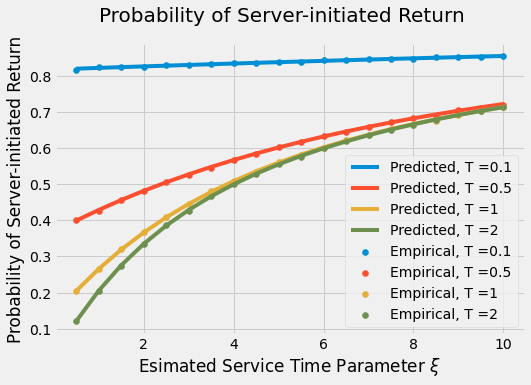

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # probability of decay crossing
    ax1.scatter(xiSpace, empiricalArray[:,-1], label = sLabel)    
    ax1.plot(xiSpace, predictedArray[:,-1], label = pLabel)

ax1.legend()
ax1.set_xlabel('Esimated Service Time Parameter ' + r'$\xi$')
ax1.set_ylabel('Probability of Server-initiated Return')

fig.suptitle(r'Probability of Server-initiated Return', fontsize = 20)

Text(0.5, 0.98, 'Means and Variances of the Return Time $\\tau_\\nu$')

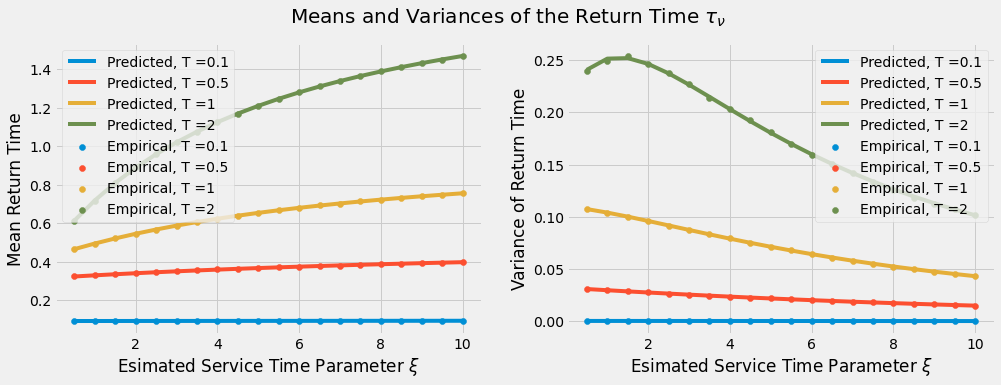

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # mean crossing time
    ax1.scatter(xiSpace, empiricalArray[:,0], label = sLabel)    
    ax1.plot(xiSpace, predictedArray[:,0], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(xiSpace, empiricalArray[:,2], label = sLabel)
    ax2.plot(xiSpace, predictedArray[:,2], label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Esimated Service Time Parameter ' + r'$\xi$')
ax1.set_ylabel('Mean Return Time')

ax2.legend()
ax2.set_xlabel('Esimated Service Time Parameter ' + r'$\xi$')
ax2.set_ylabel('Variance of Return Time')

fig.suptitle(r'Means and Variances of the Return Time $\tau_\nu$', fontsize = 20)

Text(0.5, 0.98, 'Means and Variances of the Return Queue Length $Q_\\nu$')

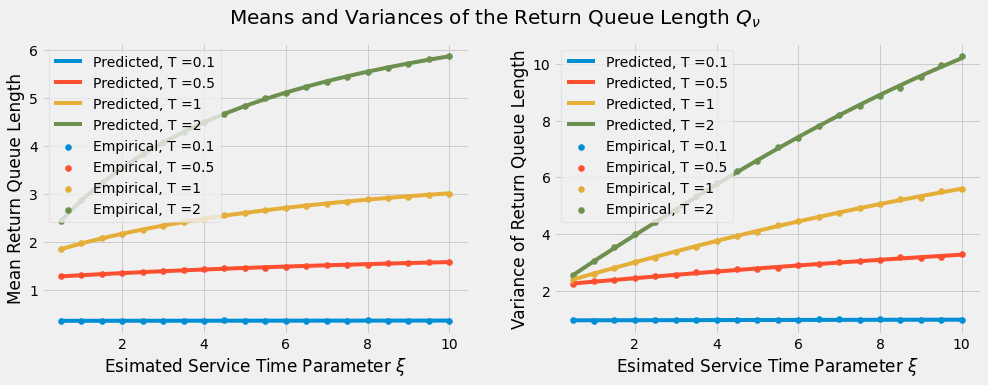

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

for i in range(len(tList)):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, T =' + str(tList[i])
    pLabel = 'Predicted, T =' + str(tList[i])

    # mean crossing time
    ax1.scatter(xiSpace, empiricalArray[:,1], label = sLabel)    
    ax1.plot(xiSpace, predictedArray[:,1], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(xiSpace, empiricalArray[:,3], label = sLabel)
    ax2.plot(xiSpace, predictedArray[:,3], label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Esimated Service Time Parameter ' + r'$\xi$')
ax1.set_ylabel('Mean Return Queue Length')

ax2.legend()
ax2.set_xlabel('Esimated Service Time Parameter ' + r'$\xi$')
ax2.set_ylabel('Variance of Return Queue Length')

fig.suptitle(r'Means and Variances of the Return Queue Length $Q_\nu$', fontsize = 20)

## Heat Maps of Server-Initiated Probability, Mean Return Time, and Mean Queue Time

Each is computed vs. $p$ and $xi$.

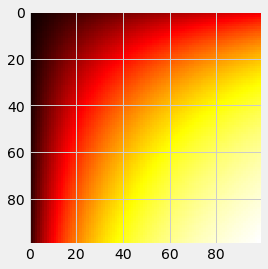

In [15]:
pSpace = np.linspace(0.1, 10, 100)
xiSpace = np.linspace(0.1, 1, 100)

p, xi = np.meshgrid(pSpace, xiSpace)

probabilities = vacationReturnProbability(2, xi, p, 1)

plt.imshow(probabilities, cmap='hot', interpolation='nearest')

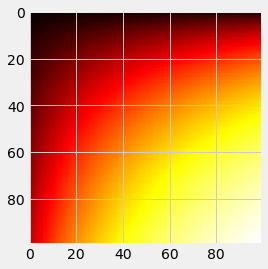

In [16]:
pSpace = np.linspace(0.1, 1, 100)
xiSpace = np.linspace(0.1, 10, 100)

p, xi = np.meshgrid(pSpace, xiSpace)

meanTime = returnTimeMean(2, xi, p, 1)

plt.imshow(meanTime, cmap='hot', interpolation='nearest')

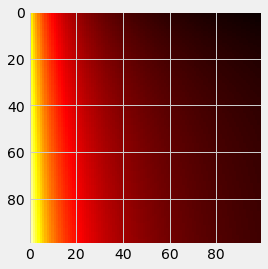

In [17]:
xiSpace = np.linspace(0.1, 10, 100)
pSpace = np.linspace(0.1, 1, 100)

p, xi = np.meshgrid(pSpace, xiSpace)

meanQueue = returnQueueMean(2, xi, p, 1)

plt.imshow(meanQueue, cmap='hot', interpolation='nearest')